# Computer Vision Project-Phase 1: Sample Notebook

This notebook is the **Phase 1** deliverable (image grid, preprocessing, and feature matching). 

---

## 1. Setup & Imports

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.dpi'] = 120


## 2. Helper functions


In [ ]:
def load_images_from_folder(folder, exts=('jpg','jpeg','png')):
    # load teh dataset 
    files = []
    for ext in exts:
        files.extend(sorted(glob.glob(os.path.join(folder, f'*.{ext}'))))
    return [cv2.imread(p) for p in files], files


def show_image_grid(imgs, cols=5, figsize=(12,6), titles=None):
    # display the images as a grid
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=figsize)
    
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((10,10,3))
        plt.imshow(im)
        plt.axis('off')
        if titles:
            plt.title(titles[i], fontsize=9)
    plt.tight_layout()
    plt.show()


def to_gray(img):
    # changes the image to gray scale
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


## 3. Loading captured images

Uses the helpers defined above to load the images and display them as a grid

Loaded 18 images


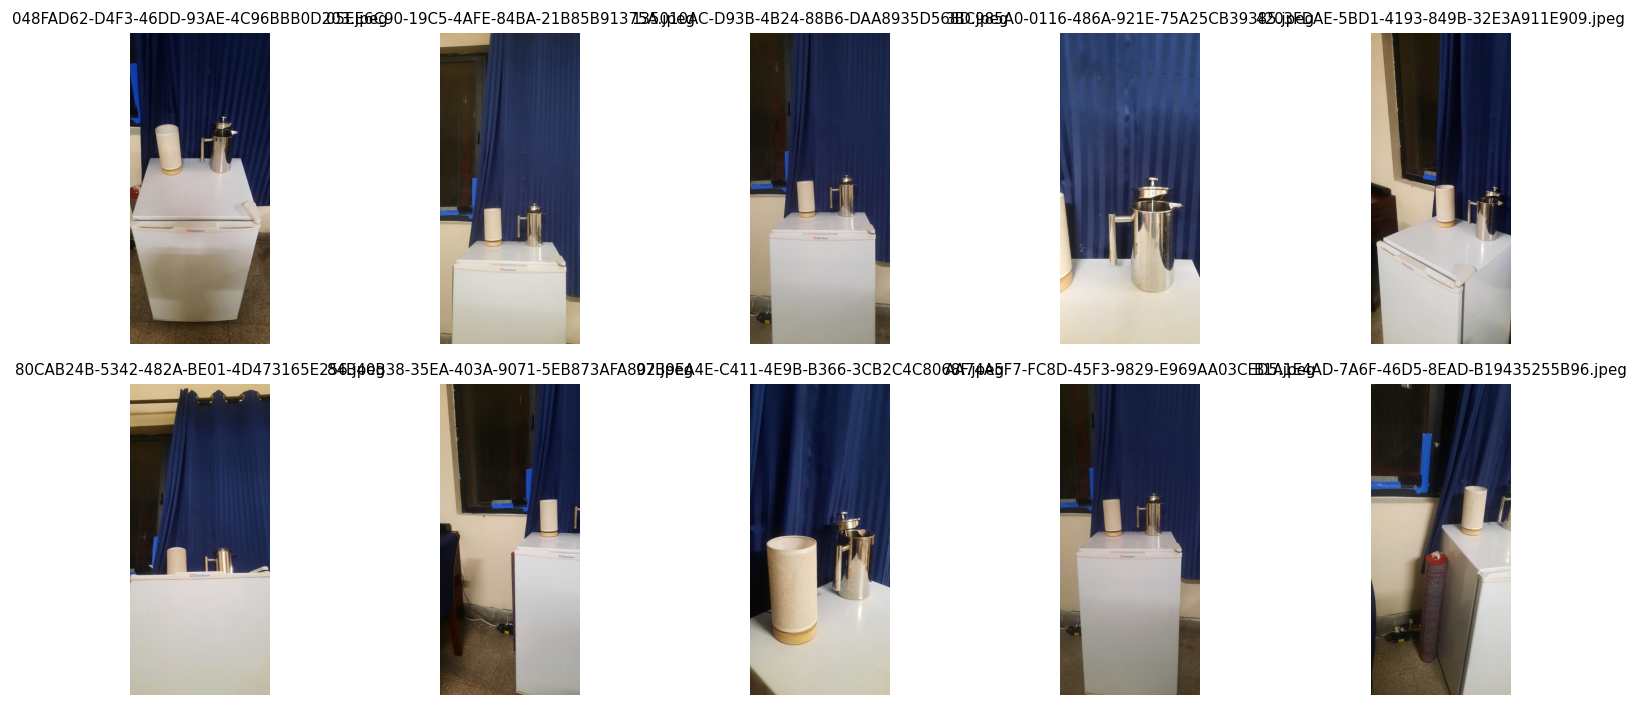

In [ ]:
images_folder = './Dataset'
imgs, img_paths = load_images_from_folder(images_folder)
print(f'Loaded {len(imgs)} images')

# Show at least 10 images in a grid: 
show_image_grid(imgs[:10], cols=5, figsize=(14,6), titles=[Path(p).name for p in img_paths[:10]])

## 4. Preprocessing

Applies preprocessing techniques on the dataset. First we resize, then we convert to greyscale apply clahe and display the preprocessed images as a grid asw



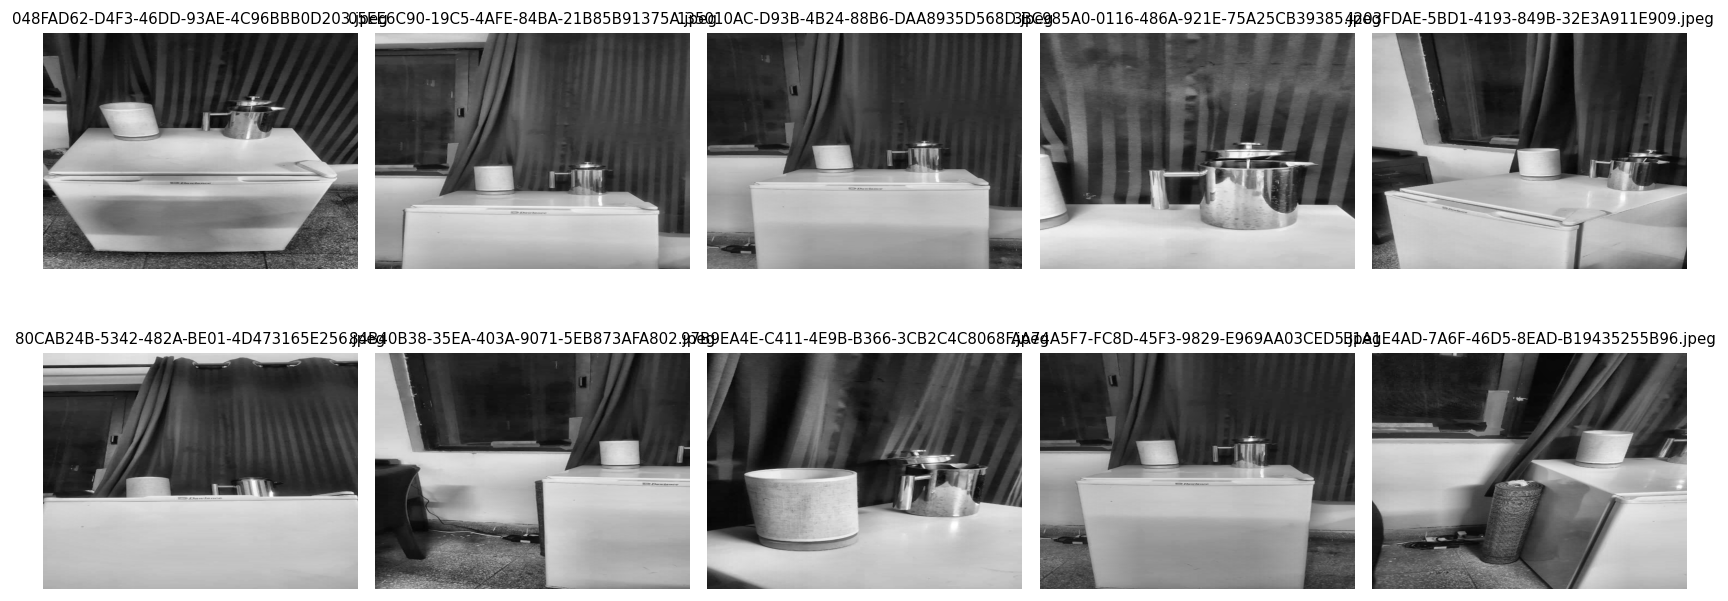

In [ ]:
# resize and histogram equalization:
PREPROCESS = True
PREPROCESS_SIZE = (1024, 768) 

proc_imgs = []
for im in imgs:
    if im is None:
        proc_imgs.append(None)
        continue
    im_r = cv2.resize(im, PREPROCESS_SIZE) if PREPROCESS else im.copy()
    gray = to_gray(im_r)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)
    im_out = cv2.cvtColor(gray_eq, cv2.COLOR_GRAY2BGR)
    proc_imgs.append(im_out)

show_image_grid(proc_imgs[:10], cols=5, figsize=(14,6), titles=[Path(p).name for p in img_paths[:10]])

## 5. Feature Detection and Matching (SIFT)

In [ ]:
# Create the feature detector and matcher
try:
    sift = cv2.SIFT_create()
    detector = sift
    print('Using SIFT')
except Exception:
    orb = cv2.ORB_create(5000)
    detector = orb
    print('SIFT unavailable; using ORB')
    
is_sift = hasattr(detector, 'detectAndCompute') and detector.__class__.__name__.lower().startswith('sift')
matcher = cv2.BFMatcher(cv2.NORM_L2 if is_sift else cv2.NORM_HAMMING, crossCheck=False)

# Helpers for Keypoint detection and description 
def detect_and_compute(img):
    gray = to_gray(img)
    kps, desc = detector.detectAndCompute(gray, None)
    return kps, desc


def match_with_ratio(desc1, desc2, ratio=0.75):
    raw_matches = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for m_n in raw_matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < ratio * n.distance:
            good.append(m)
    return good

Using SIFT


## 6. Visualize matches for image pairs
Takes 2 images and runs feature matching on the image pair then displays the image pair and draws the matches 

Matching 048FAD62-D4F3-46DD-93AE-4C96BBB0D203.jpeg <-> 05EE6C90-19C5-4AFE-84BA-21B85B91375A.jpeg
Found 32 good matches


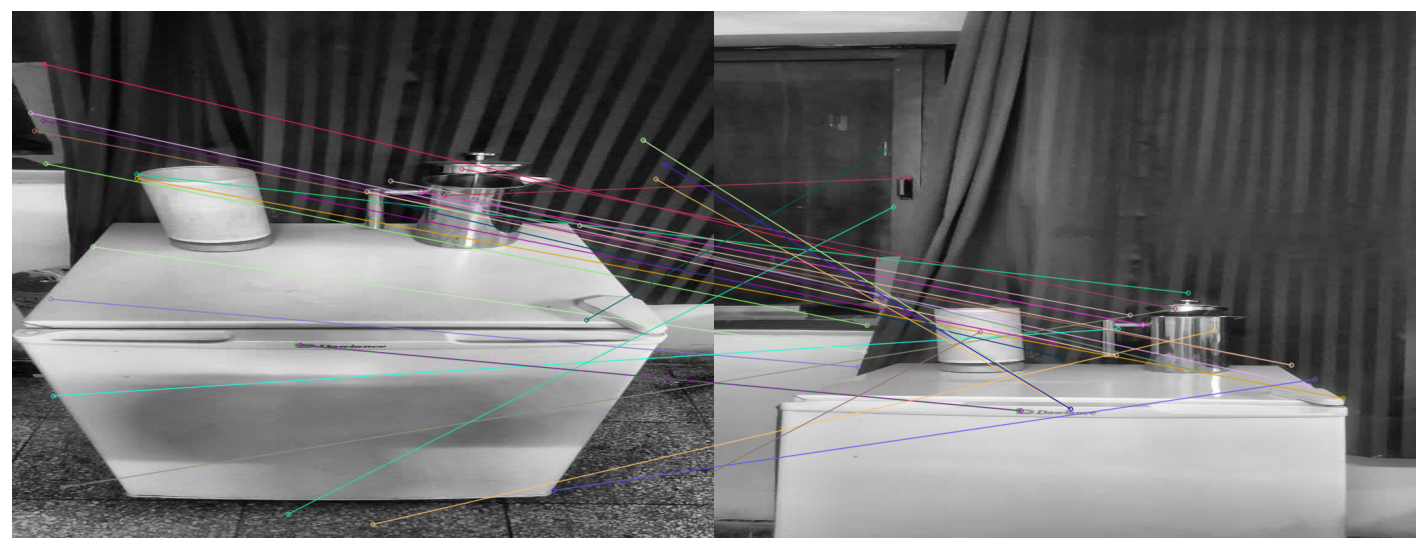

Matching 05EE6C90-19C5-4AFE-84BA-21B85B91375A.jpeg <-> 135010AC-D93B-4B24-88B6-DAA8935D568D.jpeg
Found 136 good matches


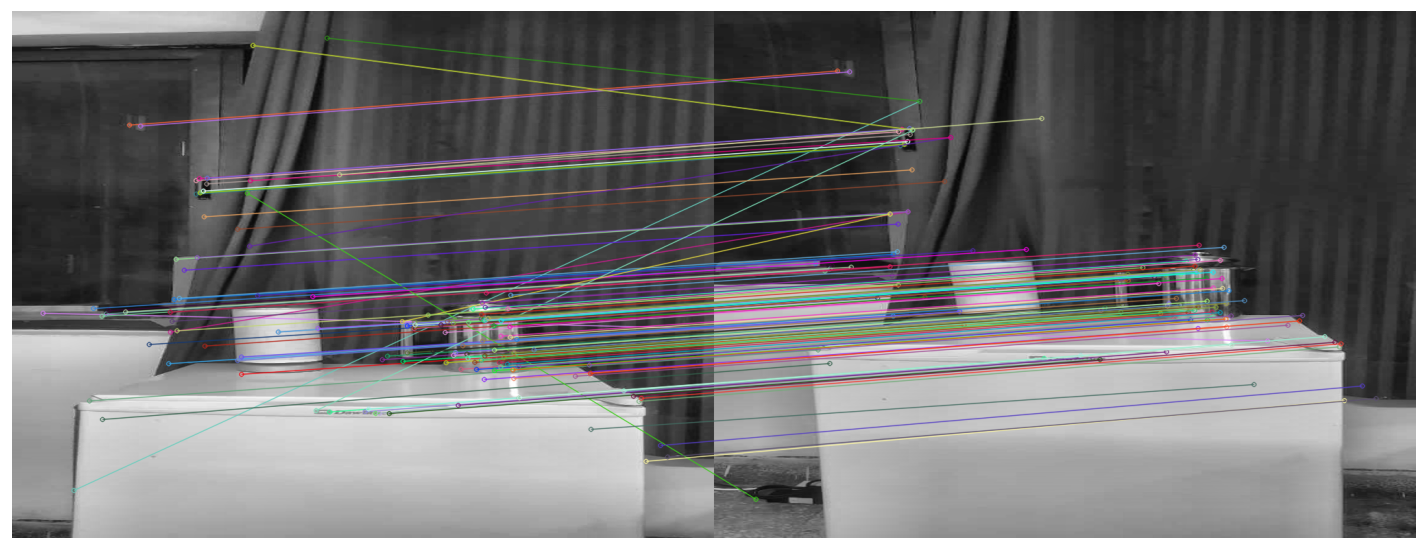

Matching 135010AC-D93B-4B24-88B6-DAA8935D568D.jpeg <-> 3BC985A0-0116-486A-921E-75A25CB39385.jpeg
Found 15 good matches


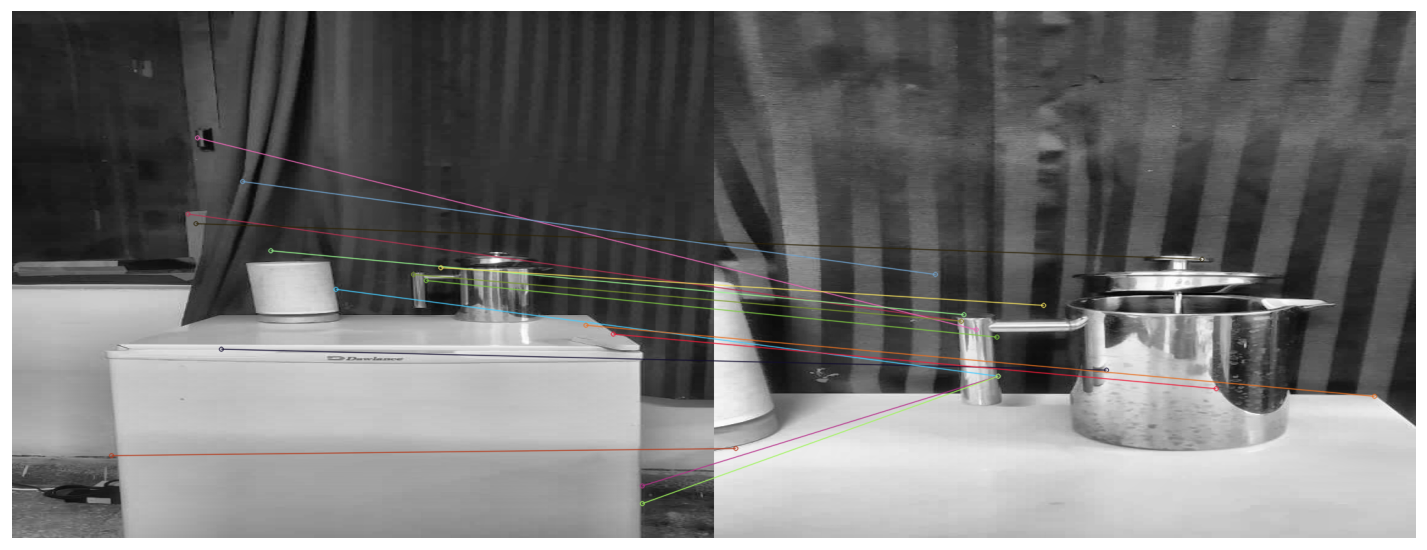

Matching 3BC985A0-0116-486A-921E-75A25CB39385.jpeg <-> 4203FDAE-5BD1-4193-849B-32E3A911E909.jpeg
Found 11 good matches


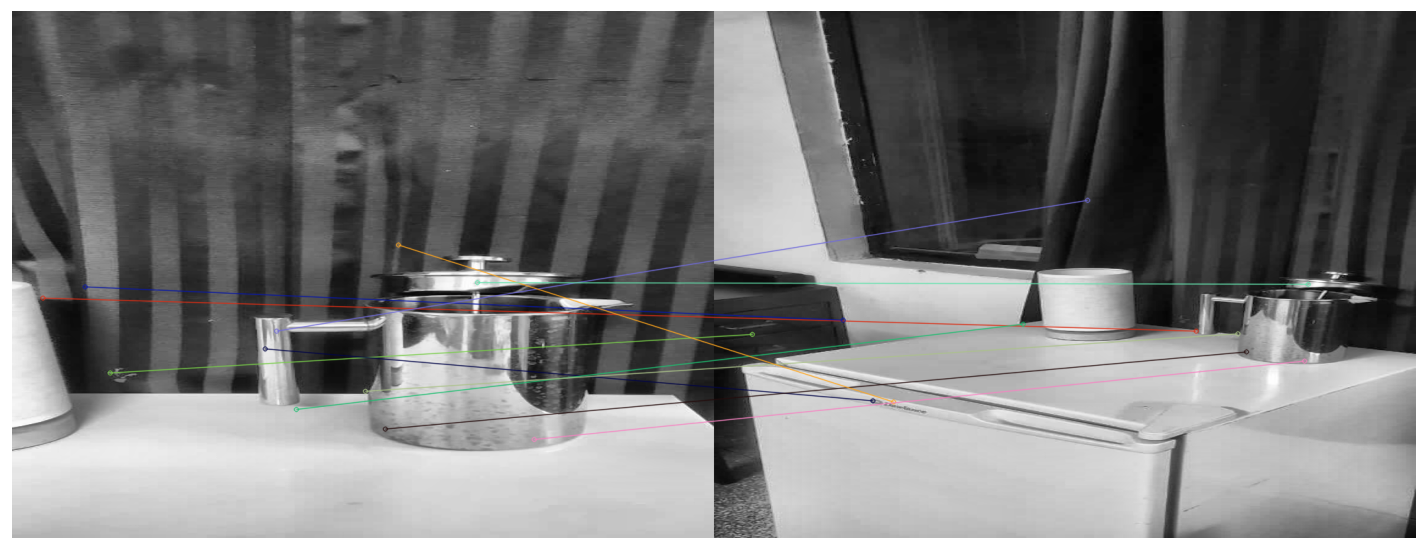

In [ ]:
# Choose indices for consecutive pairs:
N = min(5, len(proc_imgs))
pair_indices = [(i, i+1) for i in range(N-1)]

for a, b in pair_indices:
    print('Matching', Path(img_paths[a]).name, '<->', Path(img_paths[b]).name)
    im1 = proc_imgs[a]; im2 = proc_imgs[b]
    kps1, desc1 = detect_and_compute(im1)
    kps2, desc2 = detect_and_compute(im2)
    if desc1 is None or desc2 is None:
        print('No descriptors in one of the images — skipping')
        continue
    good = match_with_ratio(desc1, desc2, ratio=0.75)
    print(f'Found {len(good)} good matches')

    # Draw top matches (cap to 200)
    draw_matches = min(200, len(good))
    matched_img = cv2.drawMatches(im1, kps1, im2, kps2, good[:draw_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    show_image_grid([matched_img], cols=1, figsize=(12,6))

## 7. Save match visualizations


In [7]:
out_dir = './match_vis'
os.makedirs(out_dir, exist_ok=True)
for i,(a,b) in enumerate(pair_indices):
    im1 = proc_imgs[a]; im2 = proc_imgs[b]
    kps1, desc1 = detect_and_compute(im1)
    kps2, desc2 = detect_and_compute(im2)
    if desc1 is None or desc2 is None:
        continue
    good = match_with_ratio(desc1, desc2)
    matched_img = cv2.drawMatches(im1, kps1, im2, kps2, good[:200], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    outpath = os.path.join(out_dir, f'matches_{i}_{Path(img_paths[a]).stem}_{Path(img_paths[b]).stem}.png')
    cv2.imwrite(outpath, matched_img)
    print('Saved', outpath)

Saved ./match_vis/matches_0_048FAD62-D4F3-46DD-93AE-4C96BBB0D203_05EE6C90-19C5-4AFE-84BA-21B85B91375A.png
Saved ./match_vis/matches_1_05EE6C90-19C5-4AFE-84BA-21B85B91375A_135010AC-D93B-4B24-88B6-DAA8935D568D.png
Saved ./match_vis/matches_2_135010AC-D93B-4B24-88B6-DAA8935D568D_3BC985A0-0116-486A-921E-75A25CB39385.png
Saved ./match_vis/matches_3_3BC985A0-0116-486A-921E-75A25CB39385_4203FDAE-5BD1-4193-849B-32E3A911E909.png
